<a href="https://colab.research.google.com/github/simonperrott/stockatron/blob/master/stockatron_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install yfinance

In [47]:
import yfinance as yt
import numpy as np
import pandas as pd
from matplotlib import pyplot

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15
pd.options.display.max_columns = 20

pyplot.style.use("dark_background")

            Open  High   Low  Close    Volume  Dividends  Stock Splits
Date                                                                  
1999-01-04 54.61 59.33 53.31  59.16  39292200          0          0.00
1999-01-05 54.78 64.88 53.25  62.25  62873200          0          3.00
1999-01-06 68.19 70.19 67.00  69.00  36176600          0          0.00


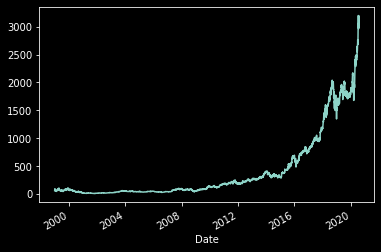

In [64]:
amzn = yt.Ticker('AMZN')
df_amzn = amzn.history(start='1999-01-01')
print(df_amzn.head(3))
df_amzn['Close'].plot()
pyplot.show()

In [65]:
from sklearn.preprocessing import StandardScaler

# We want to estimate whether a stock price's change will move by more than 5% over the coming 5 trading days and in which direction the proce will move.
def create_labels(df:pd.DataFrame, threshold:float, numDaysForwardToPredict = -5):
  df['CloseAfter5Days'] = df['Close'].shift(numDaysForwardToPredict, axis=0)
  df['change'] = 100* (df['CloseAfter5Days'] - df['Open'])/df['Open']
  df['change'].hist()
  pyplot.show()

  # 0 HOLD => -ve threshold < % Change < +ve threshold
  # 1 BUY => % Change > +ve threshold
  # -1 SELL => % Change < -ve threshold
  df['label'] = df['change'].apply(lambda x: 1 if x > threshold else -1 if x < -1*threshold else 0)
  print(df.tail(12))

  scaler = StandardScaler() # or MinMaxScaler(feature_range=(-1, 1))
  df['change'] = scaler.fit_transform(df[['change']])
  df_subset = df.loc[:, ['change', 'label']]
  df_subset.dropna(inplace=True)
  print(df_subset.tail(5))
  return df_subset

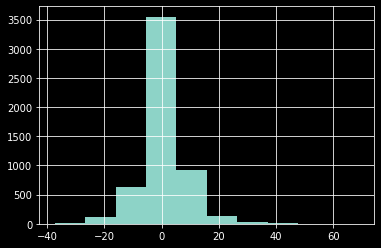

              Open    High     Low   Close   Volume  Dividends  Stock Splits  \
Date                                                                           
2020-07-13 3251.06 3344.29 3068.39 3104.00  7720400          0          0.00   
2020-07-14 3089.00 3127.38 2950.00 3084.00  7231900          0          0.00   
2020-07-15 3080.23 3098.35 2973.18 3008.87  5788900          0          0.00   
2020-07-16 2971.06 3032.00 2918.23 2999.90  6394200          0          0.00   
2020-07-17 3009.00 3024.00 2948.45 2961.97  4761300          0          0.00   
2020-07-20 3000.20 3201.36 2994.02 3196.84  7598200          0          0.00   
2020-07-21 3232.49 3240.58 3105.72 3138.29  6135000          0          0.00   
2020-07-22 3125.00 3150.00 3065.26 3099.91  4104200          0          0.00   
2020-07-23 3098.27 3098.27 2970.00 2986.55  5656900          0          0.00   
2020-07-24 2930.00 3031.58 2888.00 3008.91  5632400          0          0.00   
2020-07-27 3062.00 3098.00 3015.77 3055.

In [66]:
df = create_labels(df_amzn, 5.0)

In [67]:
from pandas import DataFrame
from pandas import concat

def dataframe_to_supervised(df, input_cols, pred_col, n_timesteps=1, n_out=1, dropnan=True):
	"""
	Time series -> LSTM supervised learning dataset.
	Arguments:
		data: Sequence of observations as a NumPy array.
    input_cols: list of strings identifying the input feature columns to use in shifting
		n_timesteps: Number of lag observations as input (X).
		pred_col: the name of the column we want to predict
    n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_timesteps, 0, -1):
		cols.append(df[input_cols].shift(i))
		names += [f'{c}(t-{i})' for c in input_cols]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[pred_col].shift(-i))
		names += [f'{pred_col}']
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [68]:
# Baseline 1st Model uses:
# one feature = price daily change
# batches of timeseries of prices going back 7 days
# predicts change after next 5 days of trading
num_time_steps = 7
df_price_ts = dataframe_to_supervised(df, ['change'], 'label', num_time_steps, 1)
print(df_price_ts.shape)
df_price_ts.tail(10)

(5415, 8)


,change(t-7),change(t-6),change(t-5),change(t-4),change(t-3),change(t-2),change(t-1),label
Date,,,,,,,,
2020-07-08,1.19,1.37,1.77,1.86,1.16,0.64,0.02,0
2020-07-09,1.37,1.77,1.86,1.16,0.64,0.02,-0.15,0
2020-07-10,1.77,1.86,1.16,0.64,0.02,-0.15,-0.56,-1
2020-07-13,1.86,1.16,0.64,0.02,-0.15,-0.56,-1.00,0
2020-07-14,1.16,0.64,0.02,-0.15,-0.56,-1.00,-0.30,0
2020-07-15,0.64,0.02,-0.15,-0.56,-1.00,-0.30,0.11,0
2020-07-16,0.02,-0.15,-0.56,-1.00,-0.30,0.11,-0.01,0
2020-07-17,-0.15,-0.56,-1.00,-0.30,0.11,-0.01,-0.02,0
2020-07-20,-0.56,-1.00,-0.30,0.11,-0.01,-0.02,-0.09,0


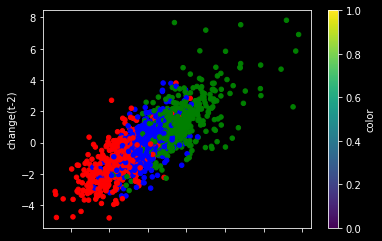

In [54]:
# Plot the data classes using only the previous 2 days change
df_price_ts['color'] = df_price_ts['label'].apply(lambda x: 'blue' if x==0 else 'red' if x==-1 else 'green')
df_price_ts.plot.scatter(x='change(t-1)', y='change(t-2)', c='color')
pyplot.show()

In [69]:
# Choose Training data (avoiding data leak by training set having no data points in future of test set)
train = df_price_ts.loc['2005' :'2017']

In [70]:
# Explore balance of classes in Training set
label_groupings = train['label'].value_counts()
print(label_groupings)

 0    2358
 1     564
-1     350
Name: label, dtype: int64


In [71]:
# Balance classes in Training set by Down sampling randomly.
# This is important for accuracy as I'm more interested in accurately predicting cases -1 and +1 rather than 0.
from sklearn.utils import resample

min_label_count = label_groupings.min()
df_list = []
# Separate by label
for label in label_groupings.index:
  df_for_label = train[train.label == label]
  df_list.append(
      resample(  
          df_for_label, 
          replace = False,    # sample without replacement
          n_samples = min_label_count     # to match minority class
          )) 

train_balanced = pd.concat(df_list)

print(train_balanced.shape) 
# Display new class counts
train_balanced.label.value_counts()

(1050, 8)


-1    350
 1    350
 0    350
Name: label, dtype: int64

In [72]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

training_set = train_balanced.values

train_X, train_y = training_set[:, :-1], training_set[:, -1]
print(train_X.shape)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
train_y_encoded = encoder.transform(train_y)
# convert integers to dummy variables (i.e. one hot encoded)
train_y_dummy = np_utils.to_categorical(train_y_encoded)
#train_y_ohe = np_utils.to_categorical(train_y)

# Test 2019 - 2020
test = df_price_ts.loc['2019-07-01' :'2020'].values
test_X, test_y = test[:, :-1], test[:, -1]

test_y_encoded = encoder.transform(test_y)
# convert integers to dummy variables (i.e. one hot encoded)
test_y_dummy = np_utils.to_categorical(test_y_encoded)

n_features = 1

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape(train_X.shape[0], num_time_steps, n_features)
test_X = test_X.reshape(test_X.shape[0], num_time_steps, n_features)

print(train_X.shape, train_y_dummy.shape, test_X.shape, test_y_dummy.shape)

(1050, 7)
(1050, 7, 1) (1050, 3) (267, 7, 1) (267, 3)


Train on 1050 samples, validate on 267 samples
Epoch 1/150
 - 1s - loss: 1.1544 - accuracy: 0.3429 - val_loss: 1.0715 - val_accuracy: 0.3895
Epoch 2/150
 - 0s - loss: 1.0198 - accuracy: 0.3790 - val_loss: 1.0569 - val_accuracy: 0.2210
Epoch 3/150
 - 0s - loss: 0.9697 - accuracy: 0.4048 - val_loss: 1.0414 - val_accuracy: 0.2210
Epoch 4/150
 - 0s - loss: 0.9233 - accuracy: 0.4505 - val_loss: 1.0274 - val_accuracy: 0.2285
Epoch 5/150
 - 0s - loss: 0.9248 - accuracy: 0.4895 - val_loss: 1.0106 - val_accuracy: 0.2734
Epoch 6/150
 - 0s - loss: 0.9232 - accuracy: 0.4981 - val_loss: 1.0002 - val_accuracy: 0.3146
Epoch 7/150
 - 0s - loss: 0.8859 - accuracy: 0.5229 - val_loss: 0.9953 - val_accuracy: 0.3109
Epoch 8/150
 - 0s - loss: 0.8868 - accuracy: 0.5486 - val_loss: 0.9866 - val_accuracy: 0.3483
Epoch 9/150
 - 0s - loss: 0.8750 - accuracy: 0.5257 - val_loss: 0.9824 - val_accuracy: 0.3483
Epoch 10/150
 - 0s - loss: 0.8605 - accuracy: 0.5410 - val_loss: 0.9744 - val_accuracy: 0.3708
Epoch 11/150

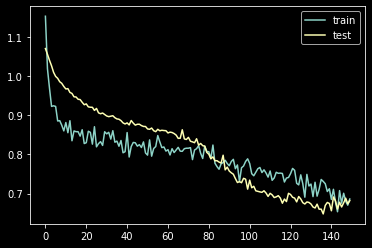

In [75]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout

# design network 
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(num_time_steps, n_features), dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# fit network
history = model.fit(train_X, train_y_dummy, epochs=150, batch_size=20, validation_data=(test_X, test_y_dummy), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# Questions to answer...
# 1. Why is Test loss smaller than Training loss?
# 2. Why is Test loss increasing with iterations?

In [ ]:
# TODO Experiements: 
# Add regularizer to bias & weights
# Try with more timestamps
# Try more layers
# Try different batch size 
# Try different optimiser
# Try adding other parallel timeseries like the change of the S&P500 over the time period or the volume of the stock traded over the time period (some code below)

In [ ]:
# S&P500
gspc = yt.Ticker('^GSPC')
print(gspc.info)
df_gspc = gspc.history(start='1997-05-15')
df_gspc

In [ ]:
def standardize_volume(df):
  df['Volume_n'] = np.log(df['Volume'])
  #df.hist(column='Volume_n')
  # standardize into z-scores
  df['Volume_n'] = (df['Volume_n'] - df.mean()['Volume_n'])/ df.std()['Volume_n']
  #df.plot(y='Volume_n')

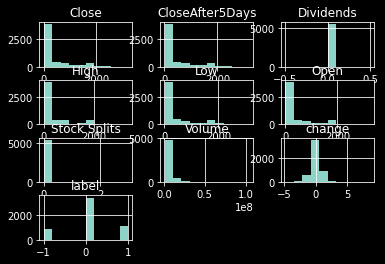

In [76]:
# Include Volume!
df_amzn.hist()
pyplot.show()
# DailyChange is Gaussian so can Standardize into z-scores
# Log Scaling for Volume (as it has a Power Law Dist) & then normalize if it has a Guassian Dist after Log Scaling.

In [ ]:
standardize_volume(df_amzn)

In [ ]:
# S&P500
gspc = yt.Ticker('^GSPC')
df_gspc = gspc.history(start='1999-01-01')
add_dailyChange(df_gspc)
add_normalized_dailyChange(df_gspc)

df_amzn['S&P_DailyChange_n'] = df_gspc['DailyChange_n']
df_amzn